In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
import warnings
warnings.filterwarnings('ignore')

# A. EDA

1. url: the restaurant’s Zomato URL
2. name: the restaurant’s name
3. online_order: whether the restaurant accepts online orders or not (yes/no)
4. book_table: whether the customers can book tables at the restaurant (yes/no)
5. rate: the overall rating given to the restaurant on Zomato (0-5)
6. votes: the number of people who have rated the restaurant
7. location: location of the restaurant
8. rest_type: the type of the restaurant (such as quick bites, casual dining, etc.)
9. cuisines: types of cuisines served at the restaurant
10. approx_cost(for two people): approximate costs for 2 people’s meal (Rupee)
11. listed_in(type): category of the restaurant (delivery, dine-out, etc.)
12. sell_beverages: whether the restaurant sells beverages
13. sell_chinese_food: whether the restaurant sells Chinese food
14. sell_thai_food: whether the restaurant sells Thai food
15. sell_indian_food: whether the restaurant sells Indian food
16. sell_mediterranean_food: whether the restaurant sells Mediterranean food
17. sell_fast_food: whether the restaurant sells fast food
18. sell_desserts: whether the restaurant sells desserts

In [65]:
df = pd.read_csv('3B.tsv', sep = '\t')
df.head(5)

,url,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,sell_fast_food,sell_desserts
0,https://www.zomato.com/bangalore/faasos-1-vasa...,Faasos,Yes,No,3.8,101,Vasanth Nagar,Delivery,"North Indian, Biryani, Fast Food",500,Delivery,no,no,no,yes,no,yes,no
1,https://www.zomato.com/bangalore/khanapur-expr...,Khanapur Express,No,No,NaN,0,JP Nagar,Quick Bites,"North Indian, Rajasthani",500,Delivery,no,no,no,yes,no,no,no
2,https://www.zomato.com/bangalore/russh-gastrop...,Russh Gastropub,No,No,4.2,1279,Church Street,Pub,"Continental, Italian, Burger","1,100",Drinks & nightlife,no,no,no,no,no,yes,no
3,https://www.zomato.com/bangalore/bangalir-rann...,Bangalir Rannaghar,No,No,2.9,58,Bannerghatta Road,Quick Bites,"Bengali, North Indian, Chinese",250,Dine-out,no,yes,no,yes,no,no,no
4,https://www.zomato.com/bangalore/natural-mumba...,Natural Mumbai Kulfi,Yes,No,3.5,8,BTM,Dessert Parlor,Ice Cream,130,Delivery,no,no,no,no,no,no,yes


## Checking missing & Duplicate data

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          15000 non-null  object
 1   name                         15000 non-null  object
 2   online_order                 15000 non-null  object
 3   book_table                   15000 non-null  object
 4   rate                         12736 non-null  object
 5   votes                        15000 non-null  int64 
 6   location                     14992 non-null  object
 7   rest_type                    14931 non-null  object
 8   cuisines                     14988 non-null  object
 9   approx_cost(for two people)  14908 non-null  object
 10  listed_in(type)              15000 non-null  object
 11  sell_beverages               14988 non-null  object
 12  sell_chinese_food            14988 non-null  object
 13  sell_thai_food               14

In [67]:
df[df.duplicated()].any()

,0
url,False
name,False
online_order,False
book_table,False
rate,False
votes,False
location,False
rest_type,False
cuisines,False
approx_cost(for two people),False


In [68]:
df.isnull().sum()

,0
url,0
name,0
online_order,0
book_table,0
rate,2264
votes,0
location,8
rest_type,69
cuisines,12
approx_cost(for two people),92


## Feature Selection

In [69]:
df = df.drop(['url', 'votes', 'listed_in(type)', 'online_order'], axis = 1)

## Dropping missing data

In [71]:
df.dropna(subset=['location', 'rest_type', 'cuisines', 'approx_cost(for two people)',
                  'sell_beverages', 'sell_chinese_food',
                  'sell_thai_food', 'sell_indian_food', 'sell_mediterranean_food',
                  'sell_fast_food', 'sell_desserts'],
          axis=0,
          inplace=True)

## Fixing Data type

In [72]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda x: str(x).replace(',', '') if pd.notnull(x) else x)
df['approx_cost(for two people)'] = pd.to_numeric(df['approx_cost(for two people)'], errors='coerce')
df['cuisines'] = df['cuisines'].apply(lambda x: str(x).replace(',', '') if pd.notnull(x) else x)

## Converting numerical to categorical

In [73]:
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['rate'] = df['rate'].fillna(0)

In [74]:
bins = [0, 3, 4, 5]
labels = ['low', 'medium', 'high']
df['RateScore'] = pd.cut(df['rate'], bins=bins, labels=labels, right=False)

## Decoding

In [75]:
df['name'] = df['name'].apply(lambda x: x.encode('latin1').decode('utf-8', 'ignore') if isinstance(x, str) else x)
df['name'] = df['name'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x) if isinstance(x, str) else x)
df['name'] = df['name'].str.replace("'", "", regex=False)

## Distribution of ratings

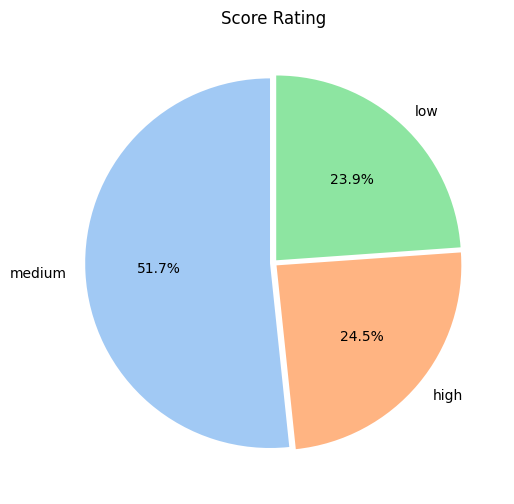

In [76]:
data = df['RateScore'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Score Rating')
plt.show()

## Restaurant Types distribution

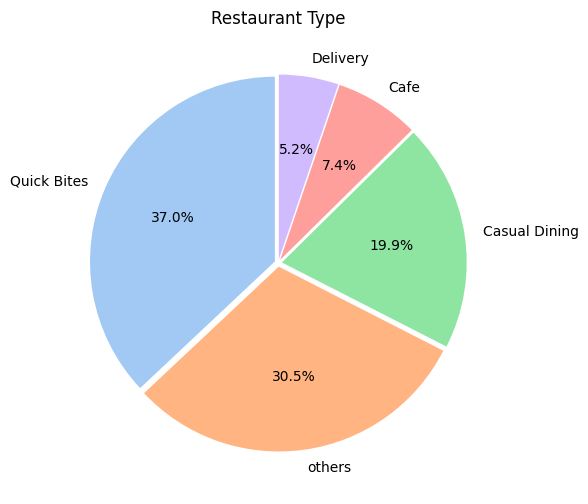

In [77]:
df1 = df
rest_type_count = df1['rest_type'].value_counts()
df1['rest_type'] = df1['rest_type'].apply(lambda x: x if rest_type_count[x] >= 0.05 * len(df) else 'others')
data = df1['rest_type'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Restaurant Type')
plt.show()

# Boxplots

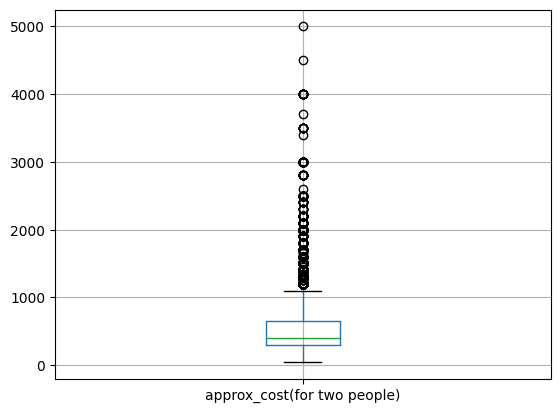

In [78]:
boxplot = df.boxplot(column = ['approx_cost(for two people)'])

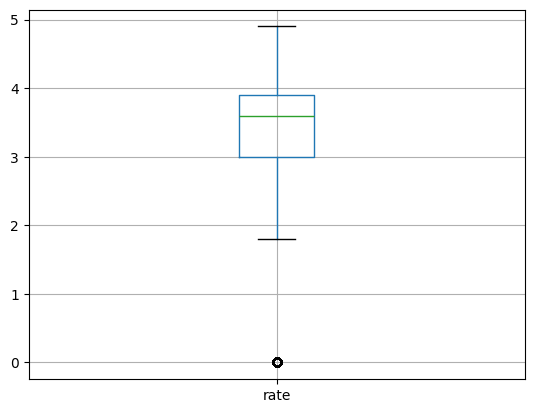

In [79]:
boxplot = df.boxplot(column = ['rate'])

# B.Model

## Vectorizing the data

In [80]:
indices = pd.Series(df.index)

df['combined'] = df['RateScore'].astype(str) + ' ' + \
                  df['cuisines'].astype(str) + ' ' + \
                  df['rest_type'].astype(str) + ' ' + \
                  df['sell_beverages'].astype(str) + ' ' + \
                  df['sell_chinese_food'].astype(str) + ' ' + \
                  df['sell_thai_food'].astype(str) + ' ' + \
                  df['sell_indian_food'].astype(str) + ' ' + \
                  df['sell_mediterranean_food'].astype(str) + ' ' + \
                  df['sell_fast_food'].astype(str) + ' ' + \
                  df['sell_desserts'].astype(str) + ' ' + \
                  df['location'].astype(str) + ' '

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1)
tfidf_matrix = tfidf.fit_transform(df['combined'])


cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# C. Evaluating the model

In [105]:
def recommend(cuisine, rating, Maxcost, cosine_similarities = cosine_similarities):

    recommend_restaurant = []
    similarity_scores = []

    idx = df[df['cuisines'] == cuisine].index[0]

    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    top_indexes = list(score_series.iloc[0:1000].index)

    for each in top_indexes:
        recommend_restaurant.append(list(df.index)[each])
        similarity_scores.append(score_series[each])

    df_new = pd.DataFrame(columns=['name','RateScore', 'location', 'rest_type','cuisines', 'rate', 'approx_cost(for two people)'])

    for each, score in zip(recommend_restaurant, similarity_scores):
        temp_df = df.loc[[each], ['name','RateScore', 'location', 'rest_type','cuisines', 'rate', 'approx_cost(for two people)']].copy()
        temp_df['similarity_score'] = score
        if temp_df['rate'].values[0] >= rating and temp_df['approx_cost(for two people)'].values[0] <= Maxcost:
            df_new = pd.concat([df_new, temp_df])

    df_new = df_new.drop_duplicates(subset=['name','location', 'approx_cost(for two people)'], keep='first')
    df_new = df_new.sort_values(by=['similarity_score', 'rate'], ascending=False).head(10)

    print(f'Top 5 {cuisine} Restaurants: ')

    return df_new.head(5)

In [109]:
recommend('Ice Cream', 3, 200)

Top 5 Ice Cream Restaurants: 


,name,RateScore,location,rest_type,cuisines,rate,approx_cost(for two people),similarity_score
8489,Kulfi & More,medium,BTM,others,Ice Cream,3.7,100,1.000000
9331,Natural Mumbai Kulfi,medium,BTM,others,Ice Cream,3.5,130,1.000000
5618,Kulfisthan,medium,HSR,others,Ice Cream,3.5,150,0.798460
6529,Bombay Kulfis,medium,HSR,others,Ice Cream,3.4,200,0.798460
14988,Premium Bombay Kulfi,medium,Indiranagar,others,Ice Cream,3.5,100,0.796925
